# Comparing Observed Values with Predicted Values

This shows comparison of values between different xarray `Dataset` objects.  This example *also* shows comparison between Arviz `InferenceData` objects, and shows the complications that arise with inspecting out-of-sample predictions with Arviz (at least when used with PyMC3).

In [9]:
import xarray as xr
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
idata = az.from_netcdf('cleaned_data.nc')
predictions = az.from_netcdf('cleaned_predictions.nc')

## Structure of the training data set

The data sets are drawn from hierarchical models, from an experimental design with a number of independent variables, and a single observation.

The data have been cleaned, since I am not sure to what extent they are shareable.

The `idata` dataset is the training set which was used to generate a trace.  This trace (in the `posterior` group of `idata`, originally), has been removed from the `idata` object.

As is standard Arviz `InferenceData`, the values of the independent variables (the data variables with the `factorx` names), are stored in the `constant_data` group (attribute), which is an xarray `Dataset`:

In [3]:
idata.constant_data

<xarray.Dataset>
Dimensions:     (rows: 1222)
Coordinates:
  * rows        (rows) int64 0 1 2 3 4 5 6 ... 1216 1217 1218 1219 1220 1221
Data variables:
    z(factor3)  (rows) float64 ...
    factor1     (rows) float64 ...
    factor2     (rows) float64 ...
    factor3     (rows) float64 ...
    factor4     (rows) float64 ...
Attributes:
    created_at:                 2020-03-26T15:17:56.410279
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

The observations from the experiment are stored in the `obs` variable in the `observed_data` group of the `InferenceData` (in this notebook the original data have been replaced by samples from a Gaussian RV):

In [4]:
idata.observed_data

<xarray.Dataset>
Dimensions:  (rows: 1222)
Coordinates:
  * rows     (rows) int64 0 1 2 3 4 5 6 7 ... 1215 1216 1217 1218 1219 1220 1221
Data variables:
    obs      (rows) float64 ...
Attributes:
    created_at:                 2020-03-26T15:17:56.401995
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

# Predicted data

After training the above model, we wished to evaluate its performance by comparing its predictions under nominal experimental conditions with the actual observed values for the same conditions.

*This is the part of the example that shows a cumbersome pattern of interaction with Xarray.*  If you are interested only in Xarray, the following description will probably not be of interes:

A new PyMC3 model was made, with only nominal conditions in its predictors, the posterior trace was thinned to remove variables that were functionally dependent on the predictors, and reshaped to have only four "observed" (predicted) variables (for reasons I won't go into, there are four values for each experimental subject under four values of one distinguished predictor).

Posterior samples were collected from this new model, and stored in the `predictions` `InferenceData` object.

Experimental conditions (values of independent variables):

In [5]:
predictions.predictions_constant_data

<xarray.Dataset>
Dimensions:     (rows: 4)
Coordinates:
  * rows        (rows) int64 0 1 2 3
Data variables:
    z(factor3)  (rows) float64 ...
    factor1     (rows) float64 ...
    factor2     (rows) float64 ...
    factor3     (rows) float64 ...
    factor4     (rows) float64 ...
Attributes:
    created_at:                 2020-03-26T16:08:38.124116
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

Predicted values

In [7]:
predictions.predictions

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 2000, factor2: 4, rows: 4)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * rows     (rows) int64 0 1 2 3
  * factor2  (factor2) object '00' '01' '10' '11'
Data variables:
    obs      (chain, draw, rows) float64 ...
    err_sd   (chain, draw, factor2) float64 ...
Attributes:
    created_at:                 2020-03-26T16:08:38.100882
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

# Making comparisons

In order to compare values between Datasets, we neet use `where`, which I have been finding quite cumbersome.  Here's an example of how I have been doing things.

## Here is the ugly bit!

First, I have to create a mask to use:

In [8]:
from numpy import logical_and as land
def nominal_conditions(dataset):
    conds = land(dataset['factor1'] == 30, dataset['factor3'] == 0.0003)
    conds = land(conds, dataset['factor4'] == 0)
    return conds

Even once I have wrapped up *that* bit of ugliness, it's still ugly to use it, as seen in the plotting example below:

```
conds = nominal_conditions(predictions.predictions_constant_data)
conds = land(conds, predictions.predictions_constant_data['factor2'] == i)
redictions.predictions['obs'].where(conds)
```

Here's an example use plotting:

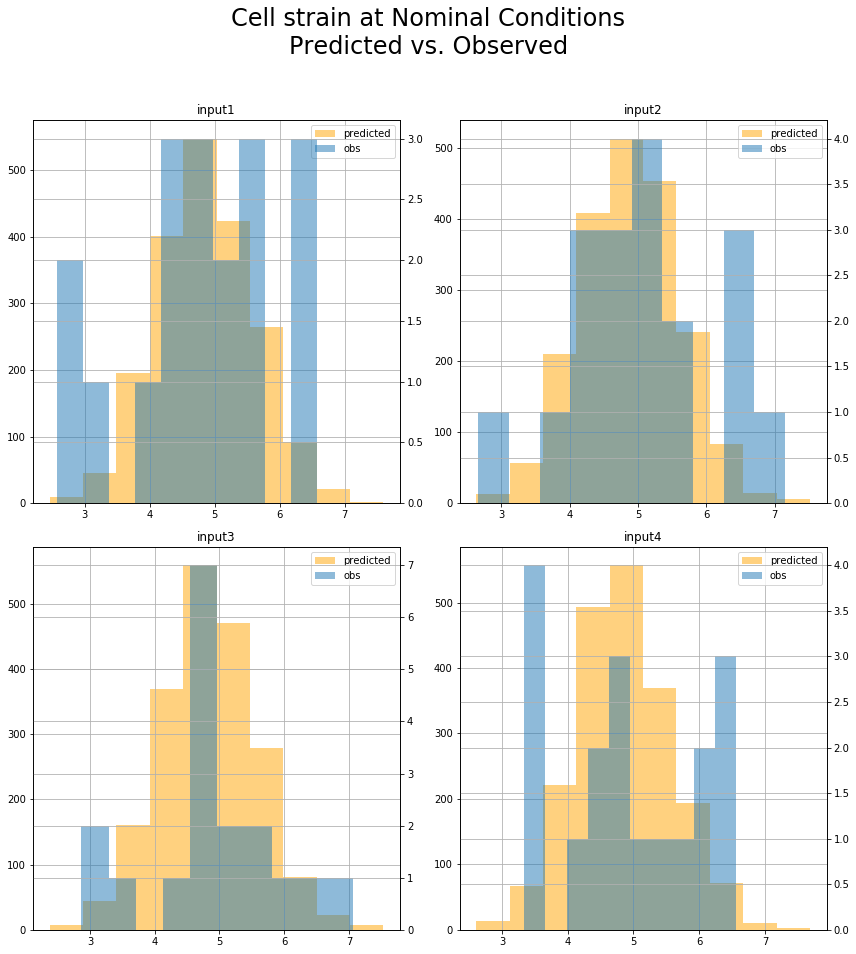

In [13]:
fig, axeses = plt.subplots(nrows=2, ncols=2)
axeses = axeses.flatten()
fig.set_size_inches((12, 12))
fig.suptitle('Cell strain at Nominal Conditions\nPredicted vs. Observed', fontsize=24, y=1.10)
for i, istring in enumerate(['input1', 'input2', 'input3', 'input4']):
    ax = axeses[i]
    conds = nominal_conditions(predictions.predictions_constant_data)
    conds = land(conds, predictions.predictions_constant_data['factor2'] == i)
    predictions.predictions['obs'].where(conds).to_dataframe().hist(ax=ax,
                                                                 label='predicted', alpha=0.5,
                                                                 color='orange')
    new_ax = ax.twinx()
    conds = land(nominal_conditions(idata.constant_data), idata.constant_data['factor2'] == i)
    idata.observed_data['obs'].where(conds).to_series().dropna().hist(ax = new_ax, label='obs', alpha=0.5)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = new_ax.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc=0)
    ax.set_title('%s'%istring)
fig.tight_layout()